## Task 4.  Algorithms of unconditional nonlinear optimization. Stochastic and metaheuristic algorithms

### 4.1 Generate noisy data {$x_k, y_k$}, where $k = 0, 1, .. 10^{3}$, according to the rule: 

\begin{equation*}
    \\
    x_k = \frac{3k}{10^{3}},
    \; \; \;
    y_k =
    \begin{cases}
        \: -10^{2} + \delta_{k}, \; f(x_{k}) < -10^{2}
        \\
        \\
        \: f(x_{k}) + \delta_{k}, \; |f(x_{k})| \leq 10^{2},
        \\
        \\
        \: 10^{2} + \delta_{k}, \; f(x_{k}) > 10^{2}
    \end{cases}
    \; \;
    f(x) = \frac{1}{x^{2} - 3x + 2}
\end{equation*}

### where $\delta_k \sim N(0, 1)$ are values of a random variable with standard normal distribution. Approximate the data by the following rational function:

\begin{equation*}
    F(x, a, b, c, d) = \frac{ax + b}{x^{2} + cx + d}
\end{equation*}

### by means of least squares through the numerical minimization of the following function:

\begin{equation*}
    D(a, b, c, d) = \sum_{k = 0}^{1000}{(F(x_k, a, b, c, d) - y_k)^2}
\end{equation*}

### To solve the minimization problem, use Nelder-Mead algorithm, Levenberg-Marquardt algorithm and at least two of the methods among Simulated Annealing, Differential Evolution and Particle Swarm Optimization. If necessary, set the initial approximations and other parameters of the methods. Use $ \varepsilon = 0.001$ as the precision; at most 1000 iterations are allowed. 

### Visualize the data and theapproximants obtained in a single plot. Analyze and compare the results obtained (in terms of number of iterations, precision, number of function evaluations, etc.).


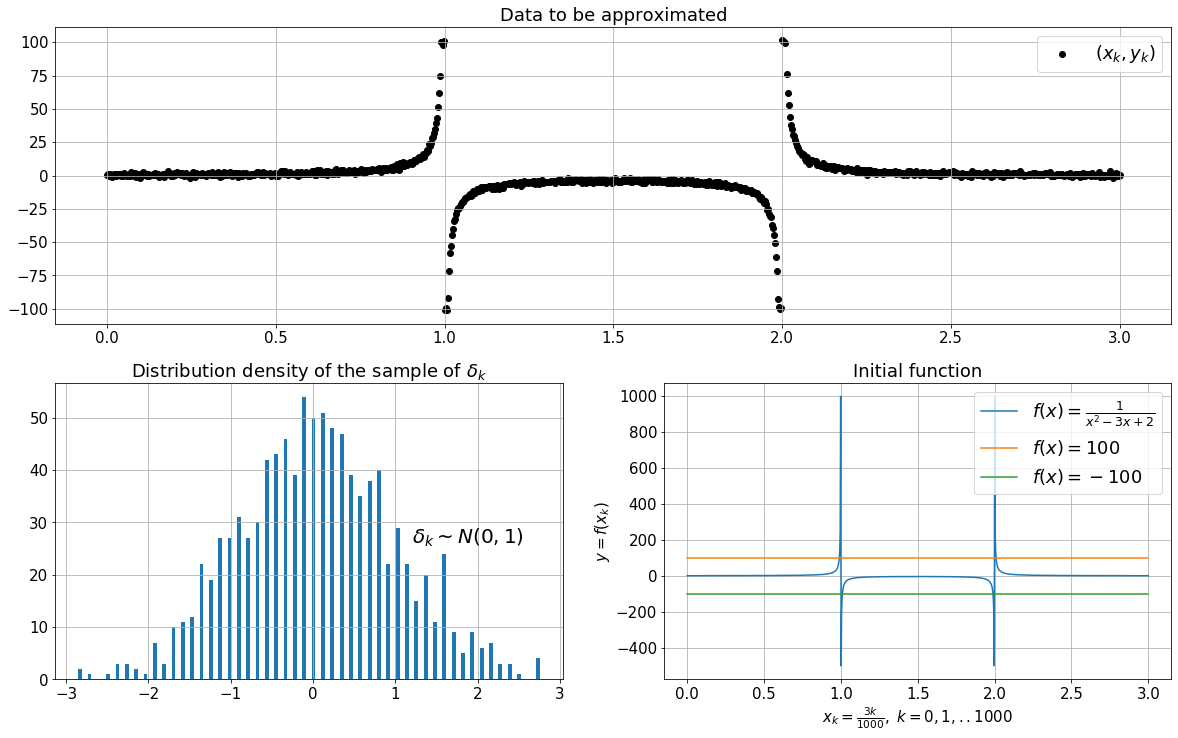

In [308]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares

global x_arr
global y_arr

# Data generation part:

def initial_func(x):
    return 1 / (x ** 2 - 3 * x + 2)

np.random.seed(4)
el_num = 1001
mu, sigma = 0, 1
delta_arr = np.random.normal(mu, sigma, el_num)

x_arr = np.linspace(0, 3, el_num)
y_arr = np.array([(lambda y: - 100 if (y < -100) else (100 if (y > 100) else y))(initial_func(x_arr[k])) \
                  +  delta_arr[k] for k in range(el_num)])

mpl.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize = (20, 12))
plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

plt.subplot(2, 2, 3)
plt.hist(delta_arr, bins = 50, rwidth = 0.4)
plt.text(x = 1.2, y = 26, s = r'$\delta_k \sim N(0, 1)$', fontsize = 20)
plt.title('Distribution density of the sample of $\delta_k$')
plt.grid()

plt.subplot(2, 2, 4)
x_arr = np.linspace(0, 3, el_num)
plt.plot(x_arr, initial_func(x_arr), x_arr, [100] * el_num, x_arr, [-100] * el_num)
plt.title('Initial function')
plt.legend([r'$f(x) = \frac{1}{x^2 - 3x + 2}$', r'$f(x) = 100$', r'$f(x) = -100$'], loc = 'best', fontsize = 18)
plt.xlabel(r'$x_k = \frac{3k}{1000}, \; k = 0, 1, .. 1000$')
plt.ylabel(r'$y = f(x_k)$')
plt.grid()

plt.subplot(2, 1, 1)
plt.scatter(x_arr, y_arr, c = 'k')
plt.title('Data to be approximated')
plt.legend([r'$(x_k, y_k)$'], loc = 'best', fontsize = 18)
plt.grid()
plt.show()

fig.savefig('initial_distribution.png')

In [349]:
# LM trial

def least_squares_func(args):
    
    ans = 0
    for i in range(len(x_arr)):
        ans += np.square((args[0] * x_arr[i] + args[1]) / (x_arr[i] ** 2 + args[2] * x_arr[i] + args[3]) - y_arr[i])
        
    return ans


def Levenberg_Marquardt_scipy(initial_approx = np.ones(4),  eps = 1e-3):
    
    res = least_squares(least_squares_func, initial_approx, xtol = eps)
    
    n_digits = abs(int(round(np.log10(eps))))
    params = [round(res.x[i], n_digits) for i in range(4)]
    
    return np.array(params[:] + [res.nit, res.nfev, least_squares_func(params)])


#Levenberg_Marquardt_scipy()
res = least_squares(least_squares_func, np.ones(4), method = 'lm', xtol = 1e-3)
res.nit

ValueError: Method 'lm' doesn't work when the number of residuals is less than the number of variables.

In [365]:
# Working part:

def approx_func(x, args):
    return (args[0] * x + args[1]) / (x ** 2 + args[2] * x + args[3])


def least_squares_func(args):
    return np.sum(np.square((args[0] * x_arr + args[1]) / (x_arr ** 2 + args[2] * x_arr + args[3]) - y_arr))


def gradient_num(func, args, eps = 1e-3):
    
    '''each time the gradient is calculated, the function is evaluated for 8 times'''
    
    a, b, c, d = args[:]
    
    part_deriv_a = (func([a + eps, b, c, d]) - func([a - eps, b, c, d])) / (2 * eps)
    part_deriv_b = (func([a, b + eps, c, d]) - func([a, b - eps, c, d])) / (2 * eps)
    part_deriv_c = (func([a, b, c + eps, d]) - func([a, b, c - eps, d])) / (2 * eps)
    part_deriv_d = (func([a, b, c, d + eps]) - func([a, b, c, d - eps])) / (2 * eps)
    
    return np.array([part_deriv_a,  part_deriv_b, part_deriv_c, part_deriv_d])


def Nelder_Mead(initial_approx = np.ones(4), eps = 1e-3):
    
    res = minimize(least_squares_func, initial_approx, method = 'nelder-mead', options = {'xatol': eps, 'maxiter' : 1000})
    
    n_digits = abs(int(round(np.log10(eps))))
    params = [round(res.x[i], n_digits) for i in range(4)]
    
    return np.array(params[:] + [res.nit, res.nfev, least_squares_func(params)])


def Levenberg_Marquardt(initial_approx = np.ones(4), eps = 1e-3):
        
    reg_param = 0.1
    func_eval_num, iter_num = 0, 0
    args_prev = np.array(initial_approx)
        
    jac = np.array([gradient_num(lambda args: approx_func(x_i, args), args_prev, eps = eps / 10) for x_i in x_arr])
    inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_param * np.diag(np.dot(jac.T, jac)) * np.eye(4))
        
    delta_arg = np.dot(inv_cond, np.dot(jac.T, y_arr - np.array([approx_func(x_i, args_prev) for x_i in x_arr])))
    args_curr = args_prev + delta_arg
    
    func_eval_num += 8
    iter_num += 1
    
    while (np.linalg.norm(args_curr - args_prev, np.inf) >= eps) and (iter_num < 1000):
        
        args_prev = args_curr[:]
        
        jac = np.array([gradient_num(lambda args: approx_func(x_i, args), args_prev, eps = eps / 10) for x_i in x_arr])
        inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_param * np.diag(np.dot(jac.T, jac)) * np.eye(4))
        delta_arg = np.dot(inv_cond, np.dot(jac.T, y_arr - np.array([approx_func(x_i, args_prev) for x_i in x_arr])))
        
        args_curr = args_prev + delta_arg
        
        func_eval_num += 8
        iter_num += 1
    
    n_digits = abs(int(round(np.log10(eps))))
    params = [round(args_curr[i], n_digits) for i in range(4)]
    
    return np.array(params[:] + [iter_num, func_eval_num, least_squares_func(params)])


def annealing_method(nitial_approx = np.ones(4), eps = 1e-3):
    pass


# Testing:--------------------------------------------------------------------------------------------------
algos_dict = {'Nelder-Mead algorithm': Nelder_Mead, 'Levenberg-Marquardt algorithm': Levenberg_Marquardt}
#algos_dict = {'Nelder-Mead algorithm': Nelder_Mead}
df = pd.DataFrame(columns = list(algos_dict.keys()), index = list('abcd')[:] + \
                  ['number of iterations', 'number of function evaluations', 'sum of squared deviations'])

#initial_approx = [0, 1, -3, 2]
initial_approx = np.ones(4)

for alg_name in list(algos_dict.keys()):
    
    df[alg_name] = algos_dict[alg_name](initial_approx = initial_approx, eps = 1e-5)

df

,Nelder-Mead algorithm,Levenberg-Marquardt algorithm
a,-1.005560,-2.415970
b,1.006050,0.333030
c,-2.000940,6.499720
d,1.000960,-0.891350
number of iterations,455.000000,1000.000000
number of function evaluations,759.000000,8000.000000
sum of squared deviations,137376.637982,268712.140451


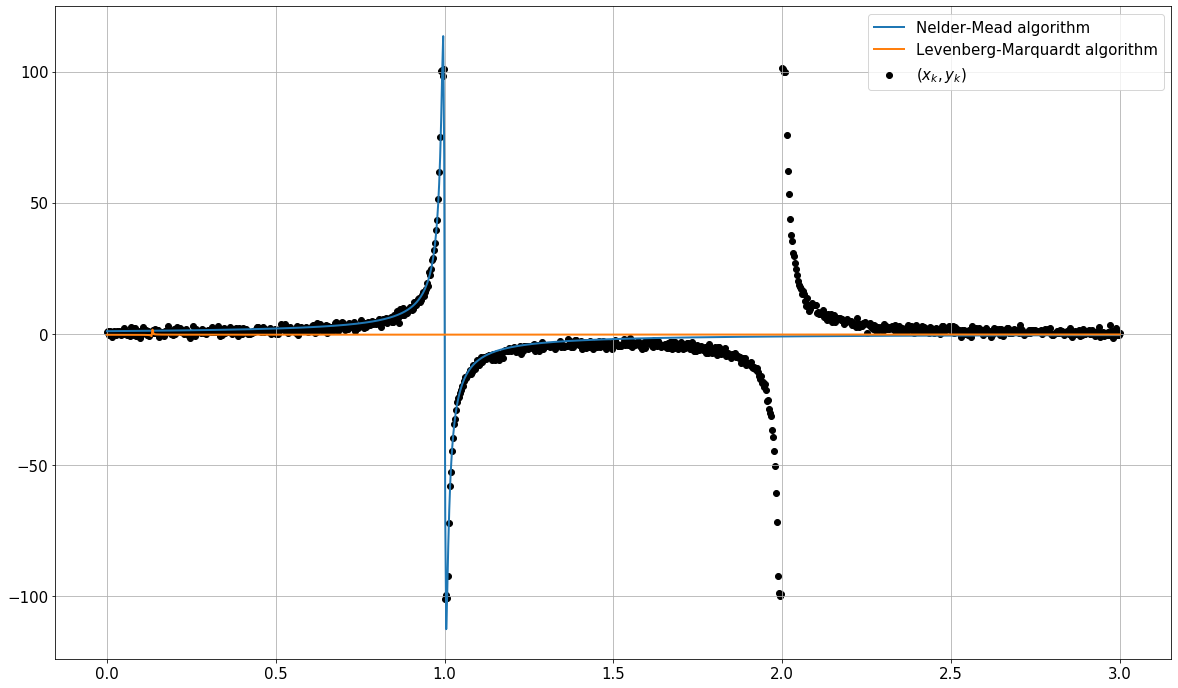

In [407]:
# Vizualization

fig, ax = plt.subplots(figsize = (20, 12))

plt.scatter(x_arr, y_arr, c = 'k', label = 'Data')

for i in range(2):
    plt.plot(x_arr, approximant_func(x_arr, df[df.columns[i]][df.index[:-3]]), linewidth = 2)

plt.legend(['Nelder-Mead algorithm', 'Levenberg-Marquardt algorithm', '$(x_k, y_k)$'])
plt.grid()

fig.savefig('first_res.png')

In [408]:
# Something for annealing method 

import random

p = 0.6
num = int(1e4)
counter = 0

for i in range(num):
    a_i = random.choices([0, 1], weights = [p, 1 - p])[0]
    if a_i == 0:
        counter += 1
        
print(counter / num)

0.6029


-------------------------------------------------------------------------------------------------------------------------------

### 4.2 Choose at least 15 cities in the world having land transport connections between them. Calculate the distance matrix for them and then apply the Simulated Annealing method to solve the corresponding Travelling Salesman Problem. 

### Visualize the results at the first and the last iteration. If necessary, use the city dataset from https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html

In [409]:
dist_file = open('15dist.txt', 'r')

dist_arr = [[] for i in range(15)]
j = 0

for line in dist_file:
    
    str_num = ''

    for i in range(len(line)):
        
        if line[i] != ' ':
            str_num += line[i]
        elif str_num != '':
            dist_arr[j].append(int(str_num))
            str_num = ''
    
    j += 1
    
dist_file.close()
np.array(dist_arr)

array([[ 0, 29, 82, 46, 68, 52, 72, 42, 51, 55, 29, 74, 23, 72, 46],
       [29,  0, 55, 46, 42, 43, 43, 23, 23, 31, 41, 51, 11, 52, 21],
       [82, 55,  0, 68, 46, 55, 23, 43, 41, 29, 79, 21, 64, 31, 51],
       [46, 46, 68,  0, 82, 15, 72, 31, 62, 42, 21, 51, 51, 43, 64],
       [68, 42, 46, 82,  0, 74, 23, 52, 21, 46, 82, 58, 46, 65, 23],
       [52, 43, 55, 15, 74,  0, 61, 23, 55, 31, 33, 37, 51, 29, 59],
       [72, 43, 23, 72, 23, 61,  0, 42, 23, 31, 77, 37, 51, 46, 33],
       [42, 23, 43, 31, 52, 23, 42,  0, 33, 15, 37, 33, 33, 31, 37],
       [51, 23, 41, 62, 21, 55, 23, 33,  0, 29, 62, 46, 29, 51, 11],
       [55, 31, 29, 42, 46, 31, 31, 15, 29,  0, 51, 21, 41, 23, 37],
       [29, 41, 79, 21, 82, 33, 77, 37, 62, 51,  0, 65, 42, 59, 61],
       [74, 51, 21, 51, 58, 37, 37, 33, 46, 21, 65,  0, 61, 11, 55],
       [23, 11, 64, 51, 46, 51, 51, 33, 29, 41, 42, 61,  0, 62, 23],
       [72, 52, 31, 43, 65, 29, 46, 31, 51, 23, 59, 11, 62,  0, 59],
       [46, 21, 51, 64, 23, 59, 33